In [1]:
from importlib import reload  # Python 3.4+
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from ndbc_api import NdbcApi
import concurrent.futures
from tqdm.contrib.concurrent import process_map, thread_map
from tqdm.autonotebook import tqdm
from src import * 

### Parse all NDBC buoy observations

In [2]:
buoy_stations = get_buoy_stations()


### Plot buoy locations

(<Figure size 640x480 with 1 Axes>, <GeoAxes: >)

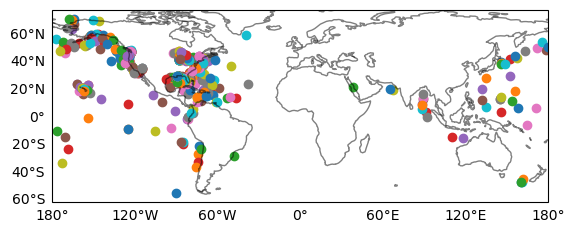

In [3]:
plot_stations(buoy_stations)

### Query all available data for California buoys between 1990 and 2016

In [12]:
# Define a range of years for which to retrieve historical records
years = range(1998, 2020)  # Example range from 1990 to 2015 inclusive

# Select a list of station IDs from the filtered dataset (here selecting the first two stations)
station_list = buoy_stations.station_id.values

# Retrieve and process historical records for the selected stations over the specified years
xsdf = get_station_records(station_list, years, sample_rate = "1Y")

Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
0.0 % done
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
I

/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/ndbc_api/api/parsers/http/station_historical.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  p_tag = soup.find('p', text=cls.LIST_IDENTIFIER)
/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/ndbc_api/api/parsers/http/station_historical.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  p_tag = soup.find('p', text=cls.LIST_IDENTIFIER)
/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/ndbc_api/api/parsers/http/station_historical.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  p_tag = soup.find('p', text=cls.LIST_IDENTIFIER)
/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/ndbc_api/api/parsers/http/station_historical.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  p

80.0 % done
82.0 % done
83.0 % done
Index(['YYYY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['YYYY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['YYYY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['YYYY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['YYYY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['YYYY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T', 'HEIGHT'], dtype='object')
Index(['#YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'T

In [13]:
# Add water temperature density to the dataset, representing the percentage of valid temperature data
xsdf = add_wtemp_coverage(xsdf)

# Add latitude and longitude coordinates to the dataset based on the reference dataset (filtered_ds)
xsdf = add_latitude_longitude(xsdf, buoy_stations)

Text(0, 0.5, '% Coverage between 1998 and 2019')

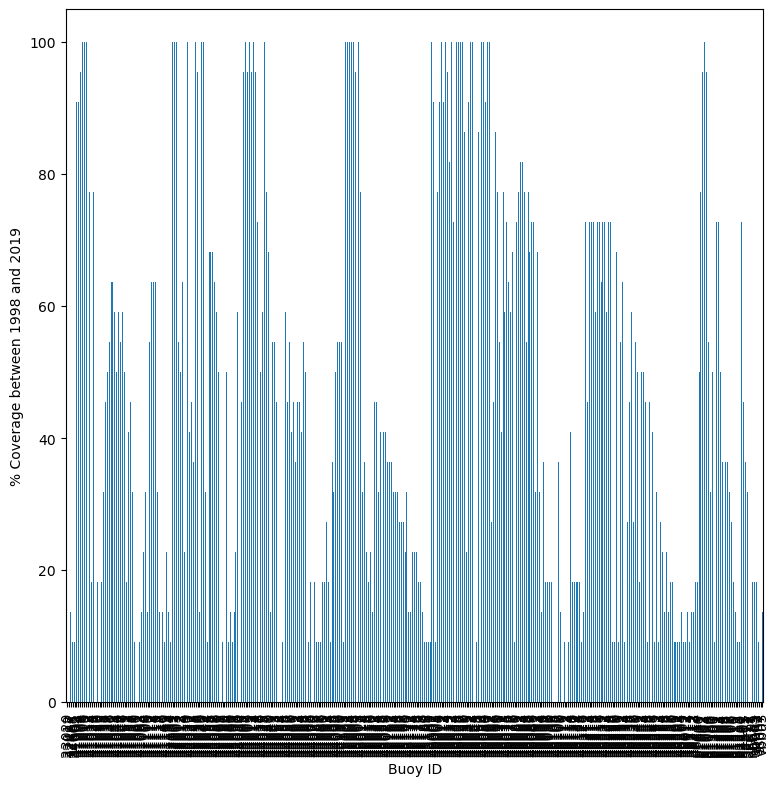

In [14]:
fig, ax = plt.subplots(figsize=(9, 9))
xsdf["wtemp_coverage"].to_series().plot.bar(ax=ax)
ax.set_xlabel("Buoy ID")
ax.set_ylabel(f"% Coverage between {years[0]} and {years[-1]}")

In [19]:
xsdf.to_netcdf("NDBC_CC_Daily.nc")

In [22]:
xsdf_filt = xsdf.where(xsdf["wtemp_coverage"] > 90)

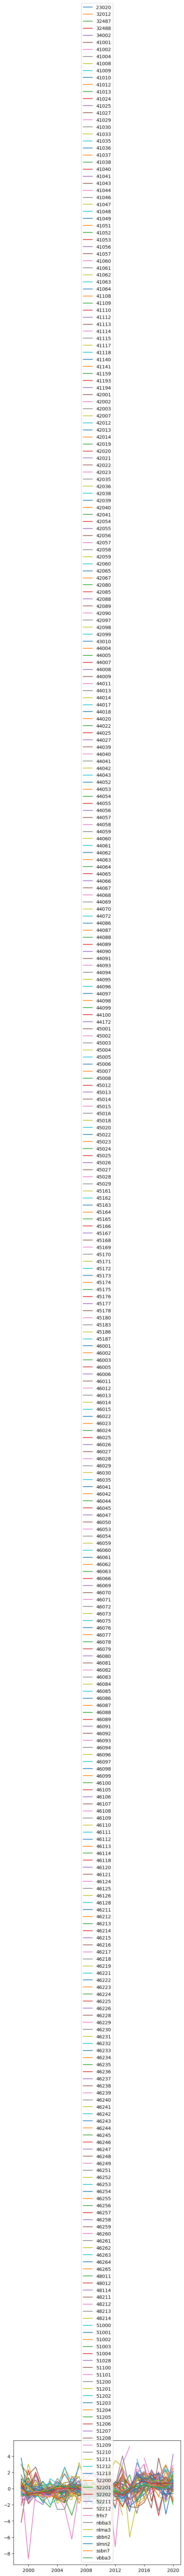

In [24]:
#plot water temperature 
fig, ax = plt.subplots()
for station in xsdf_filt["station_id"]:
    ax.plot(xsdf_filt.time, xsdf_filt.WTMP.sel(station_id = station) - xsdf_filt.WTMP.sel(station_id = station).mean("time"), label = station.values)
ax.legend()

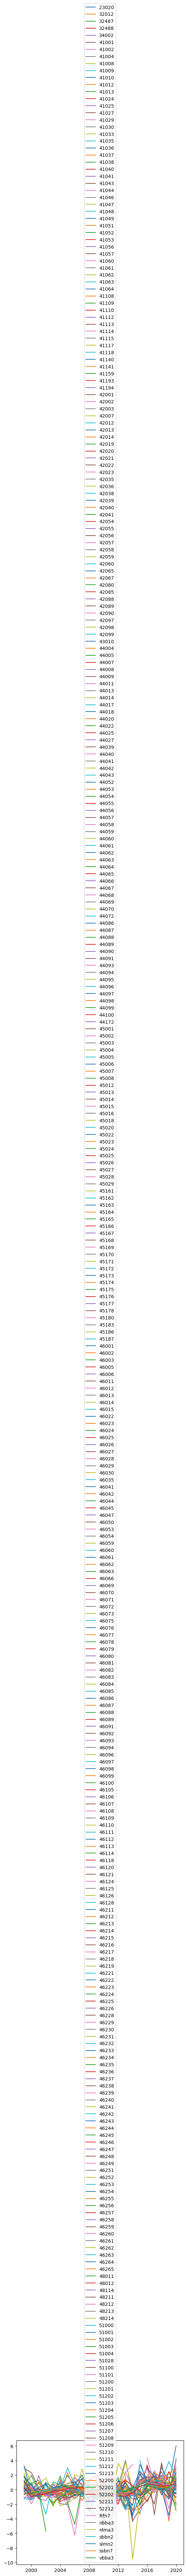

In [26]:
#plot water temperature 
fig, ax = plt.subplots()
for station in xsdf_filt["station_id"]:
    ax.plot(xsdf_filt.time, xsdf_filt.ATMP.sel(station_id = station) - xsdf_filt.ATMP.sel(station_id = station).mean("time"), label = station.values)
ax.legend()